# 01: Critic Networkの出力の量子化

### 概要
+ Critic Networkはロボットハンドの各時間ごとの角度を出力する.
+ そのまま学習しても投射にならないため, 角度を曲げる, 伸ばす, そのままに変換する [-1,0,1,].

### ToDo
+ シンプルに曲げる/曲げない/そのままでOKなのか？
+ 値の変化幅を決めるために, 各時刻毎の値の差分の分布を確認する.

## 1-1: 差分の分布の確認

In [76]:
import os
import pandas as pd
import numpy as np
import h5py

filename = os.path.join("/root/dataStore", "tmp2", "episodes", "epoch0.h5")
with h5py.File(filename, 'r') as f:
    A = np.array(f["action"],)
    
print(A.shape)

(10, 2, 100, 20)


In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook", "whitegrid", font_scale=1.5)

X = A[:,:,1:,:] - A[:,:,:-1,:]
X = X.reshape((-1,X.shape[-1],))
print(X.shape)


(1980, 20)


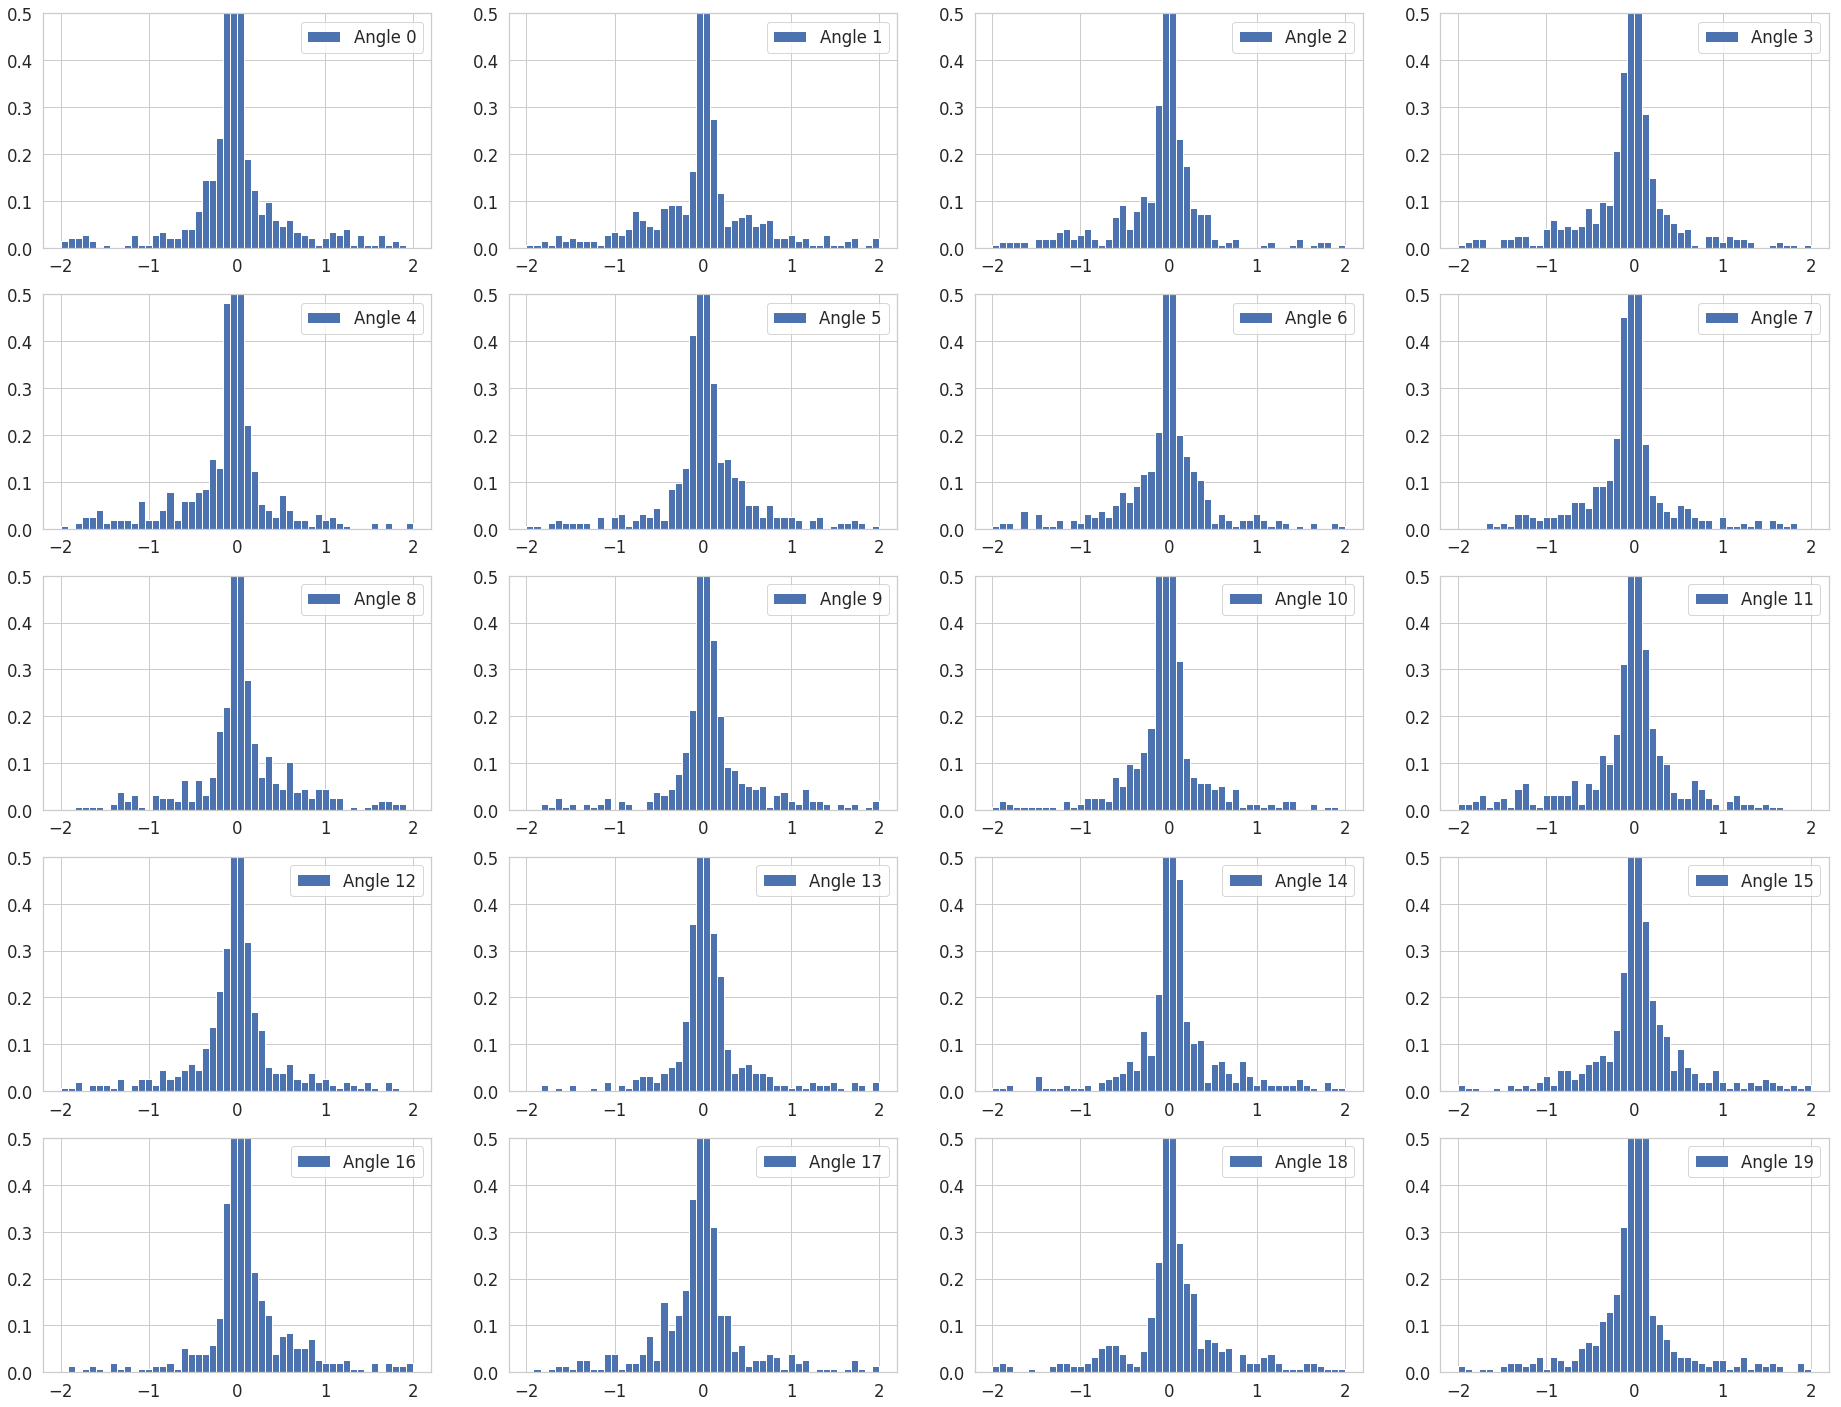

In [78]:
row, col = 5, 4

plt.figure(figsize=(8*col,5*row))
for no in range(20):
    plt.subplot(row, col, no+1)
    plt.hist(X[:, no]*(180./np.pi), density=True, bins=50, range=(-2,2), label="Angle {}".format(no))
    # plt.ylim([0,0.05])
    #plt.xlim([-45.,45.])
    #plt.xlim([-1,1.])
    plt.ylim([0,0.5])
    plt.legend()

plt.show()

## 量子化
+ しきい値を勝手に設定して, [-1.0,1]に量子化を行う.

In [128]:
import os
import pandas as pd
import numpy as np
import h5py

filename = os.path.join("/root/dataStore", "tmp2", "episodes", "epoch0.h5")
with h5py.File(filename, 'r') as f:
    A = np.array(f["action"],)
print(A.shape)

X = A[:,:,1:,:] - A[:,:,:-1,:]

(10, 2, 100, 20)


In [129]:
def resampling(X,th_min=-0.5, th_max=0.5):
    """ 量子化の実行
    
    Args.
    -----
    - x: float
    - th_min/th_max: float, threshhold [unit=degree]
    """
    _X = X.copy()
    _X[X < th_min] = -1.
    _X[X > th_max] =  1.
    _X[(X >= th_min) & (X<= th_max)] = 0
    return _X


As = resampling(X*(180./np.pi), th_min=-1., th_max=1.)
print(As.shape)

(10, 2, 99, 20)


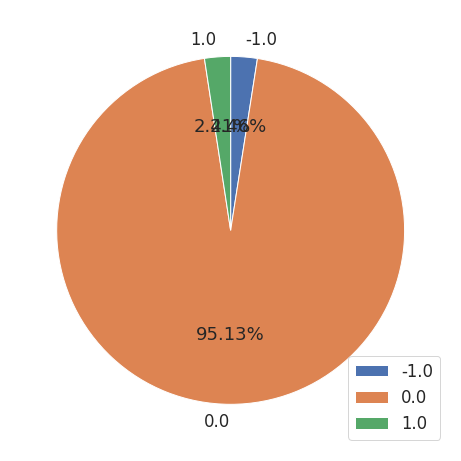

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook", "whitegrid", font_scale=1.5)

plt.figure(figsize=(8,8))
(labels, counts) = np.unique(As, return_counts=True)
plt.pie(counts, labels=labels, startangle=90, counterclock=False, autopct="%.2f%%")
plt.legend(loc="lower right")
plt.show()

In [131]:
""" 組み合わせパターンの数え上げ
"""

_As = As.reshape((-1, As.shape[-1]))
print(_As.shape,)
print(_As)

combination = list(map(list, set(map(tuple,_As))))
print(len(combination))

(1980, 20)
[[-1. -1.  1. ... -1.  1.  1.]
 [ 0.  1. -1. ...  1.  1.  0.]
 [ 1.  0.  0. ...  1. -1. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
209


(209, 20)


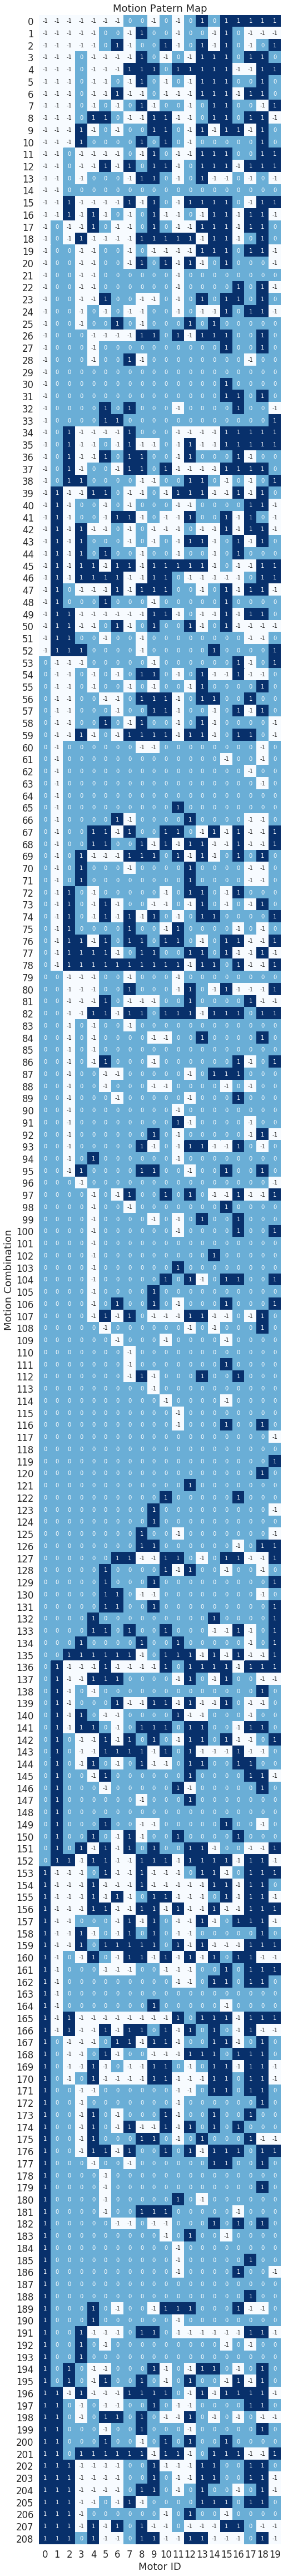

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


df_pattern = pd.DataFrame(combination).sort_values(by=list(range(20))).reset_index(drop=True)
shape = df_pattern.shape
print(shape)

plt.figure(figsize=(shape[1]*0.4,shape[0]*0.4))
sns.heatmap(df_pattern, annot=True, cmap="Blues", square=True, cbar=False)
plt.ylabel("Motion Combination")
plt.xlabel("Motor ID")
plt.title("Motion Patern Map")
plt.show()

In [133]:
""" 組み合わせパターンの数え上げ
"""
_As = As.reshape((-1, As.shape[-1]))
print(_As.shape,)
print(_As)

(labels, counts) = np.unique(_As, return_counts=True, axis=0)
print(labels.shape, counts.shape)
print(labels)
print(counts)

(1980, 20)
[[-1. -1.  1. ... -1.  1.  1.]
 [ 0.  1. -1. ...  1.  1.  0.]
 [ 1.  0.  0. ...  1. -1. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(209, 20) (209,)
[[-1. -1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1.  0.  1.]
 ...
 [ 1.  1.  1. ...  0.  0.  0.]
 [ 1.  1.  1. ...  0. -1. -1.]
 [ 1.  1.  1. ...  0.  1. -1.]]
[   1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    3    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    9    1    1    1    1    1
    2    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    5    1    1    1    1    1    1    1    1    1    1
    1    1    1    2

(209, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,counts
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,...,-1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
1,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,...,-1.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,1
2,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,-1.0,0.0,1.0,-1.0,1.0,0.0,-1.0,0.0,1.0,1
3,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,...,0.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1
4,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1


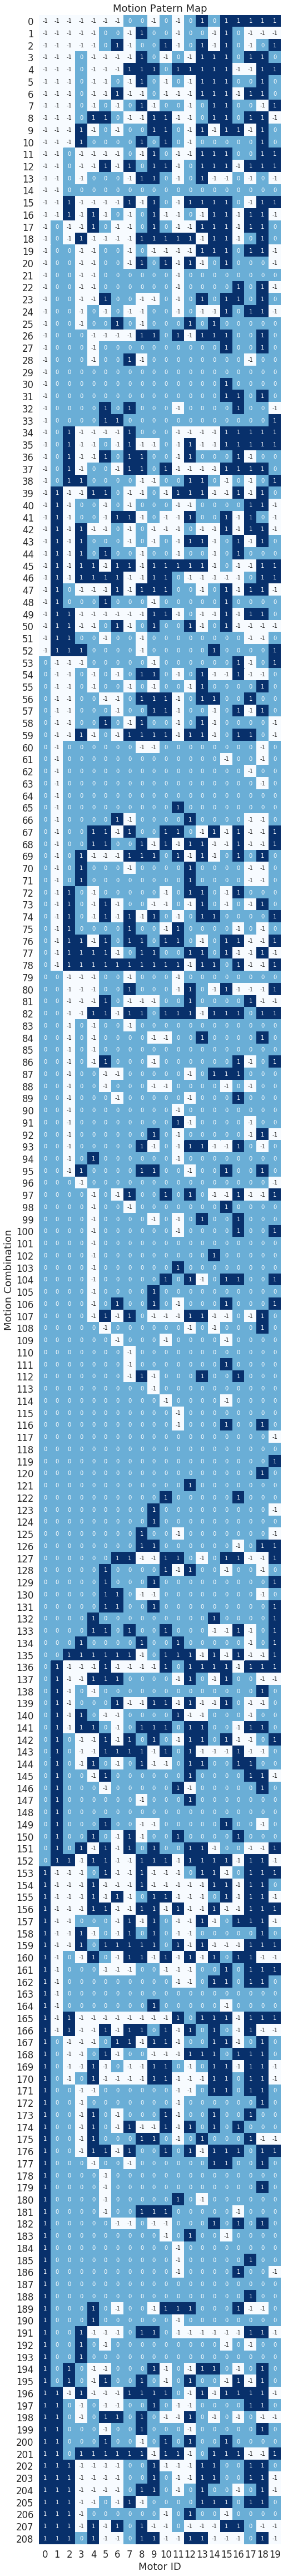

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


df_pattern = pd.DataFrame(labels).sort_values(by=list(range(20))).reset_index(drop=True)
df_pattern["counts"] = counts
shape = df_pattern.shape
print(shape)
display(df_pattern.head())

plt.figure(figsize=(shape[1]*0.4+3, shape[0]*0.4))
sns.heatmap(labels, annot=True, cmap="Blues", square=True, cbar=False)
plt.ylabel("Motion Combination")
plt.xlabel("Motor ID")
plt.title("Motion Patern Map")

plt.show()

## 量子化済みデータを変換
+ [EpisodeNo, Batch, Sequence, env.action_space]
+ ==> [EpisodeNo, Batch, Sequence, env.action_space]
+ ==> [EpisodeNo, Batch, Sequence, env.action_space, 3]

In [135]:
import os
import pandas as pd
import numpy as np
import h5py

filename = os.path.join("/root/dataStore", "tmp2", "episodes", "epoch0.h5")
with h5py.File(filename, 'r') as f:
    A = np.array(f["action"],)
print(A.shape)

X = A[:,:,1:,:] - A[:,:,:-1,:]
As = resampling(X*(180./np.pi), th_min=-1., th_max=1.)
print(X.shape, As.shape)

(10, 2, 100, 20)
(10, 2, 99, 20) (10, 2, 99, 20)


In [152]:
shape = list(As.shape) + [3]
print(shape)
As_onehot = np.eye(3)[As.ravel().astype(int)+1]
print(As_onehot.shape)
print(As_onehot.reshape(shape).shape)

[10, 2, 99, 20, 3]
(39600, 3)
(10, 2, 99, 20, 3)


In [153]:
As[0,0,0]

array([-1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,  0., -1.,  1.,
        1.,  1.,  1.,  0., -1.,  1.,  1.], dtype=float32)

In [154]:
As_onehot.reshape(shape)[0,0,0]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [144]:
As_onehot.reshape(shape).sum(axis=4)

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]],


       [[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1.